# Basic Neural Network
- Author: Minh Nguyen
- 4/25/2021
- Pytorch Classifier - just for practice
- Note on Pytorch Installation: https://pytorch.org/

In [14]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
# Load and normalize CIFAR 10 Training and Testing dataset using torchvision.

# Convert image into Tensor
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,batch_size = batch_size, shuffle = True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


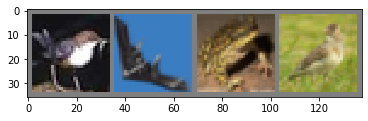

 bird plane  frog  bird


In [8]:
# Show training image
def imshow(img):
    img = img / 2 + 0.5 # unormalize
    npimg = img.numpy() # convert to numpy
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(trainloader)
im, label = dataiter.next()

imshow(torchvision.utils.make_grid(im))
print(' '.join('%5s' % classes[label[j]] for j in range(batch_size)))

In [12]:
# Defind a CNN
class Net(nn.Module):
    def __init__(self): # define layers
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x): # defind feedforward fucntion
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

In [13]:
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [15]:
# Defind a loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [17]:
# Train a Neural Network: feed training image to the network and optimize
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get [inputs, labels]
        inputs, labels = data
        
        # zero the param gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print stat for evaluation
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')


C:\Users\nguye\anaconda3\lib\site-packages\torch\autograd\__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


[1,  2000] loss: 2.210
[1,  4000] loss: 1.935
[1,  6000] loss: 1.736
[1,  8000] loss: 1.600
[1, 10000] loss: 1.535
[1, 12000] loss: 1.466
[2,  2000] loss: 1.406
[2,  4000] loss: 1.369
[2,  6000] loss: 1.330
[2,  8000] loss: 1.324
[2, 10000] loss: 1.292
[2, 12000] loss: 1.255
Finished Training


In [18]:
# Save Model:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)


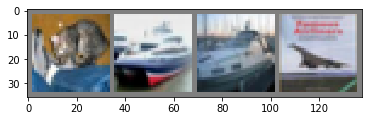

GroundTruth:    cat  ship  ship plane


In [24]:
# Test Network on the testing data - small dataset
dataiter = iter(testloader)
images, labels = dataiter.next() # Testing images and labels

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [25]:
# Load the saved model
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [26]:
outputs = net(images) # testing labels

In [27]:
# The output has 10 class, so printout the one with the highest prediction rate
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat   car   car plane


In [36]:
# Test Network on the whole dataset
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += label.size(0) # each batch has 4 images, thus the label.size(0) = 4
        correct += (predicted == labels).sum().item() 
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 53 %


In [38]:
# Further Evaluation on which class is classified well and which is not
class_correct = list(0. for i in range(10)) # list of 10 class correct
class_total = list(0. for i in range(10)) # list of 10 class total for tracking

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4): 
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 66 %
Accuracy of   car : 80 %
Accuracy of  bird : 53 %
Accuracy of   cat : 26 %
Accuracy of  deer : 45 %
Accuracy of   dog : 66 %
Accuracy of  frog : 58 %
Accuracy of horse : 51 %
Accuracy of  ship : 50 %
Accuracy of truck : 38 %
